In [1]:
from argparse import Namespace
from functools import partial
from pathlib import Path
from collections import (
    OrderedDict,
    Counter)

# torch
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import default_collate
## others
from torchtext import vocab
try:
    from torchdata import datapipes as dp
    from torchdata.dataloader2 import DataLoader2
except:
    !pip install torchdata
    from torchdata import datapipes as dp
    from torchdata.dataloader2 import Dataloader2

# manipulation 
import numpy as np

# visualization 
import matplotlib.pyplot as plt

# others
from tqdm import tqdm

In [2]:
args  = Namespace(
    # data
    data_base_path = "../../data/surnames/",
    dataset = ["train","test","val"],
    
    # vocab
    mask_tkn = "<MASK>",
    ukn_tkn = "<UKN>",
    beg_tkn = "<B>",
    end_tkn = "<E>",
    
    # model
    char_embedding_size = 100,
    rnn_hidden_dim = 64,
    model_base_path = "../../models/seq_model/seq_pred/",
    model_filename = "conditional_model.pth",
    
    # training
    num_epochs = 100,
    batch_size = 128,
    learning_rate = 1e-3,
    early_stopping_criteria = 5,
    
    # running
    cuda = torch.cuda.is_available(),
    device = "cuda" if torch.cuda.is_available() else "cpu",
    seed = 1432,
)
for k,v in args._get_kwargs():
    if "base" in k:
        Path(v).mkdir(parents=True,exist_ok=True)

# Data pipe

## build pipe dict

In [3]:
def build_pipe_dict(args=args):
    pipe_dict = {}
    for fname in args.dataset:
        pipe_dict[fname] = dp.iter.FileOpener([args.data_base_path+f"{fname}.csv"]).parse_csv()
    return pipe_dict

In [4]:
pipe_dict = build_pipe_dict()
pipe_dict

{'train': CSVParserIterDataPipe,
 'test': CSVParserIterDataPipe,
 'val': CSVParserIterDataPipe}

In [5]:
{k:len(list(pipe)) for k,pipe in pipe_dict.items()}

{'train': 7684, 'test': 1648, 'val': 1648}

## build vocab dict

In [6]:
def build_vocab_dict(train_pipe):
    name_counter = Counter()
    nation_counter = Counter()
    max_seq_length = -1
    for name,nation in train_pipe:
        max_seq_length = max(max_seq_length,len(name))
        name_counter.update(name)
        nation_counter.update([nation])
        
    sort_fn = lambda kf : (-kf[1],kf[0])
    
    name_sort_tuples = sorted(name_counter.items(),key=sort_fn)
    char_vocab = vocab.vocab(ordered_dict=OrderedDict(name_sort_tuples),
                             specials=[args.mask_tkn,
                                       args.ukn_tkn,
                                       args.beg_tkn,
                                       args.end_tkn])
    char_vocab.set_default_index(char_vocab[args.ukn_tkn])
    char_vocab.max_seq_length = max_seq_length + 2
    
    nation_sort_tuples = sorted(nation_counter.items(),key=sort_fn)
    nation_vocab = vocab.vocab(ordered_dict=OrderedDict(nation_sort_tuples))
    freq = [count for _,count in nation_sort_tuples]
    nation_vocab.class_weights = 1.0 / torch.tensor(freq)
    
    return {"char":char_vocab,
            "nation":nation_vocab}

In [7]:
vocab_dict = build_vocab_dict(pipe_dict["train"])
vocab_dict

{'char': Vocab(), 'nation': Vocab()}

In [8]:
{k:len(v) for k,v in vocab_dict.items()}

{'char': 83, 'nation': 18}

In [9]:
vocab_dict["char"].max_seq_length

19

In [10]:
vocab_dict["nation"].class_weights

tensor([0.0005, 0.0006, 0.0009, 0.0018, 0.0024, 0.0025, 0.0034, 0.0055, 0.0060,
        0.0063, 0.0065, 0.0078, 0.0092, 0.0119, 0.0189, 0.0192, 0.0250, 0.0263])

## build dataset dict

In [11]:
def vectorize(name:str,char_vocab:vocab.Vocab,args=args):
    indices = [char_vocab[args.beg_tkn]]
    indices.extend(char_vocab.lookup_indices(list(name)))
    indices.append(char_vocab[args.end_tkn])
    
    from_vector = np.full(shape=char_vocab.max_seq_length,
                          fill_value=char_vocab[args.mask_tkn],
                          dtype=np.int64)
    from_indices = indices[:-1]
    from_vector[:len(from_indices)] = from_indices
    
    to_vector = np.full(shape=char_vocab.max_seq_length,
                        fill_value=char_vocab[args.mask_tkn],
                        dtype=np.int64)
    to_indices = indices[1:]
    to_vector[:len(to_indices)] = to_indices
    
    return from_vector,to_vector


def create_dataset(vocab_dict,args,row):
    from_vector , to_vector = vectorize(row[0],vocab_dict["char"],args=args)
    nation_index = vocab_dict["nation"][row[1]]
    
    return {"x":from_vector,
            "y":to_vector,
            "nation_index":nation_index}
    
def collate_fn(args,x):
    return {k:v.to(args.device)
            for k,v in default_collate(x).items()}

In [12]:
def build_dataset_dict(pipe_dict,vocab_dict,args=args):
    dataset_dict = {}
    fn = partial(create_dataset,vocab_dict,args)
    for dataset,pipe in pipe_dict.items():
        if dataset =="train":
            pipe = pipe.shuffle()
        pipe = pipe.map(fn)
        pipe = pipe.batch(args.batch_size,drop_last=True)
        pipe = pipe.collate(partial(collate_fn,args))
        dataset_dict[dataset] = pipe
    return dataset_dict

In [13]:
dataset_dict = build_dataset_dict(pipe_dict,vocab_dict,args)
dataset_dict

{'train': CollatorIterDataPipe,
 'test': CollatorIterDataPipe,
 'val': CollatorIterDataPipe}

In [14]:
{k:len(list(v)) for k,v in dataset_dict.items()}

{'train': 60, 'test': 12, 'val': 12}

In [15]:
next(iter(dataset_dict["train"]))["nation_index"].shape

torch.Size([128])

# Model

In [16]:
class SurnameGenerativeModel(nn.Module):
    def __init__(self,char_embedding_size,char_vocab_size,num_nations,
                 rnn_hidden_size,batch_first=True,padding_idx=0,
                 dropout_rate=0.5) -> None:
        super().__init__()
        self.char_embedding = nn.Embedding(embedding_dim=char_embedding_size,
                                      num_embeddings=char_vocab_size,
                                      padding_idx=padding_idx)
        
        self.nation_embedding = nn.Embedding(embedding_dim=rnn_hidden_size,
                                             num_embeddings=num_nations)
        
        self.rnn = nn.GRU(input_size=char_embedding_size,
                          hidden_size=rnn_hidden_size,
                          batch_first=batch_first)
        
        self.fc = nn.Linear(in_features=rnn_hidden_size,
                            out_features=char_vocab_size)
        
        self.dropout_rate = dropout_rate
        
    def forward(self,input,nation_index,apply_softmax=False):
        # shape [batch,max_seq]
        x_emb = self.char_embedding(input)
        # shape [batch,max_seq,char_embedding_size]
        
        # shape [batch,]
        nation_emb = self.nation_embedding(nation_index).unsqueeze(0)
        # shape [batch,rnn_hidden_size]
        
        y_out , _ = self.rnn(x_emb,nation_emb)
        # shape y_out [batch,max_seq,hidden_size]
        
        batch_size,seq_size,feat_size = y_out.size()
        y_out = y_out.contiguous().view(batch_size*seq_size,feat_size)
        # shape [batch_size*max_seq , hidden_size]
        
        y_out = self.fc(F.dropout(y_out,self.dropout_rate))
        # shape [batch_size*max_seq , char_vocab_size]
        
        if apply_softmax:
            y_out = F.softmax(y_out,dim=1)
        
        new_feat_size = y_out.shape[-1]
        y_out = y_out.view(batch_size,seq_size,new_feat_size)
        
        return y_out      

In [17]:
sample = next(iter(dataset_dict["train"]))

In [18]:
{k:v.shape for k,v in sample.items()}

{'x': torch.Size([128, 19]),
 'y': torch.Size([128, 19]),
 'nation_index': torch.Size([128])}

In [19]:
model = SurnameGenerativeModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vocab_dict["char"]),
                               num_nations=len(vocab_dict["nation"]),
                               rnn_hidden_size=args.rnn_hidden_dim).to(args.device)

model(sample['x'],sample["nation_index"]).shape

torch.Size([128, 19, 83])

# Training

## helper function

In [20]:
def normalize_size(y_pred,y_true):
    if len(y_pred.shape) == 3 :
        y_pred = y_pred.contiguous().view(-1,y_pred.size(2))
    if len(y_true.shape) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred,y_true

def sequence_loss(y_pred,y_true,mask_index):
    y_pred ,y_true = normalize_size(y_pred,y_true)
    return F.cross_entropy(y_pred,y_true,ignore_index=mask_index)

def compute_acc(y_pred,y_true,mask_index):
    y_pred ,y_true = normalize_size(y_pred,y_true)
    _,y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices,y_true).float()
    valid_indices = torch.ne(y_true,mask_index).float()
    
    n_correct = (correct_indices*valid_indices).sum().item()
    n_valid = valid_indices.sum().item()
    
    return n_correct/n_valid

In [21]:
def make_train_state(args=args):
    return {"stop_early":False,
            "early_stopping_step":0,
            "early_stopping_val":1e5,
            "epoch_index":0,
            "model_filepath":args.model_base_path+args.model_filename,
            "train_loss":[],
            "train_acc":[],
            "val_loss":[],
            "val_acc":[],
            "test_loss":-1,
            "test_acc":-1}

def update_train_state(train_state,model,args=args):
    if train_state["epoch_index"] == 0:
        torch.save(model.state_dict(),train_state["model_filepath"])
        train_state["stop_early"] = False
    
    elif train_state["epoch_index"] >= 1:
        loss_tm1 , loss_t = train_state["val_loss"][-2:]
        if loss_t >= train_state["early_stopping_val"]:
            train_state["early_stopping_step"] +=1
        else:
            torch.save(model.state_dict(),train_state["model_filepath"])
            train_state["early_stopping_step"] = 0
            
        train_state["stop_early"] = train_state["early_stopping_step"] >= args.early_stopping_criteria
    
    return train_state

## initialize

In [22]:
pipe_dict = build_pipe_dict()
vocab_dict = build_vocab_dict(pipe_dict["train"])
dataset_dict = build_dataset_dict(pipe_dict,vocab_dict,args)

In [23]:
model = SurnameGenerativeModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vocab_dict["char"]),
                               num_nations=len(vocab_dict["nation"]),
                               rnn_hidden_size=args.rnn_hidden_dim).to(args.device)
optimizer = optim.Adam(params=model.parameters(),
                       lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode="min",factor=0.5,
                                                 patience=1)
train_state = make_train_state(args)
mask_index = vocab_dict["char"][args.mask_tkn]

## Loop

In [24]:
for epoch_index in tqdm(range(args.num_epochs)):
    train_state["epoch_index"] = epoch_index
    
    # get the data
    batch_generator = DataLoader2(datapipe=dataset_dict["train"])
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        model.zero_grad()
        logits = model(batch_dict["x"],batch_dict["nation_index"])
        
        # loss
        loss = sequence_loss(logits,batch_dict["y"],mask_index)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) /(batch_idx+1)
        
        # acc
        acc_t = compute_acc(logits,batch_dict["y"],mask_index)
        running_acc += (acc_t - running_acc) / (batch_idx+1)
        
        loss.backward()
        optimizer.step()
        
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)
    
    # iterate over the val 
    batch_generator = DataLoader2(dataset_dict["val"])
    running_loss = 0.0
    running_acc = 0.0
    model.eval()
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        with torch.inference_mode():
            logits = model(batch_dict["x"],batch_dict["nation_index"])
            
            # loss
            loss = sequence_loss(logits,batch_dict["y"],mask_index)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) /(batch_idx+1)
            
            # acc
            acc_t = compute_acc(logits,batch_dict["y"],mask_index)
            running_acc += (acc_t - running_acc) / (batch_idx+1)   
            
    train_state["val_loss"].append(running_loss)         
    train_state["val_acc"].append(running_acc)
    
    scheduler.step(train_state["val_loss"][-1])
    
    if train_state["stop_early"]:
        break          

100%|██████████| 100/100 [09:12<00:00,  5.52s/it]


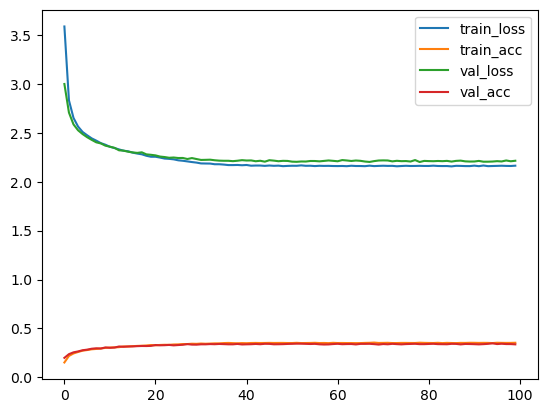

In [25]:
plt.plot(train_state["train_loss"],label="train_loss")
plt.plot(train_state["train_acc"],label="train_acc")
plt.plot(train_state["val_loss"],label="val_loss")
plt.plot(train_state["val_acc"],label="val_acc")
plt.legend();

In [27]:
batch_generator = DataLoader2(dataset_dict["test"])
running_loss = 0.0
running_acc = 0.0
model.eval()

for batch_idx,batch_dict in enumerate(batch_generator):
    with torch.inference_mode():
        logits = model(batch_dict["x"],batch_dict["nation_index"])
        
        # loss
        loss = sequence_loss(logits,batch_dict["y"],mask_index)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) /(batch_idx+1)
        
        # acc
        acc_t = compute_acc(logits,batch_dict["y"],mask_index)
        running_acc += (acc_t - running_acc) / (batch_idx+1)   
        
train_state["test_loss"] = running_loss
train_state["test_acc"] = running_acc

In [28]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.2277773022651672;
Test Accuracy: 0.33857939667949477


# Inference

In [32]:
def sample_from_model(model,char_vocab,nationalities,sample_size=20,args=args):
    num_samples = len(nationalities)
    # creating the begin index for all samples
    begin_seq_index = [char_vocab[args.beg_tkn]
                       for _ in range(num_samples)]
    # converting and add dim
    begin_seq_index = torch.tensor(begin_seq_index,dtype=torch.int64).unsqueeze(dim=1)
    
    indices = [begin_seq_index]
    nationality_indices =  torch.tensor(nationalities,dtype=torch.int64).unsqueeze(dim=0)
    h_t = model.nation_embedding(nationality_indices)
    
    for time_step in range(sample_size):
        x_t = indices[time_step]
        # shape [num_sample,1]
        x_emd_t = model.char_embedding(x_t)
        # shape [num_sample,1,emb]
        rnn_t,h_t = model.rnn(x_emd_t,h_t)
        # shape rnn_t [num_samples,1,hidden]
        # shape h_t [1,num_samples,hidden]
        pred_vector = model.fc(
            rnn_t.squeeze(dim=1)  # shape [num_sample,hidden]
            )
        # shape [num_sample,char_vocab_size]
        prob_vector = F.softmax(pred_vector,dim=1)
        # shape [num_sample,char_vocab_size]
        select = torch.multinomial(prob_vector,num_samples=1)
        indices.append(select)
    indices = torch.stack(indices)
    indices = indices.squeeze().permute(1,0)
    return indices     

In [33]:
def decode_samples(sampled_indices,char_vocab,args=args):
    decoded_surnames = []
    
    for sample_index in range(sampled_indices.shape[0]):
        surname = ""
        for time_step in range(sampled_indices.shape[1]):
            sample_item = sampled_indices[sample_index,time_step].item()
            if sample_item == char_vocab[args.beg_tkn]:
                continue
            elif sample_item == char_vocab[args.end_tkn]:
                break
            else:
                surname += char_vocab.get_itos()[sample_item]
        decoded_surnames.append(surname)
    return decoded_surnames

In [35]:
model = model.cpu()
for index in range(len(vocab_dict["nation"])):
    nationality = vocab_dict["nation"].get_itos()[index]
    print("Sampled for {}: ".format(nationality))
    sampled_indices = sample_from_model(model,vocab_dict["char"],[index]*3 )
    for sampled_surname in decode_samples(sampled_indices,vocab_dict["char"]):
        print("-  " + sampled_surname)

Sampled for English: 
-  Dontar
-  JeffAr
-  Hanbiley
Sampled for Russian: 
-  Vyajah
-  Yachltinla
-  Pezaelsh
Sampled for Arabic: 
-  Attis
-  Magain
-  Haunkie
Sampled for Japanese: 
-  Shato
-  Tiwato
-  Mibosoya
Sampled for Italian: 
-  Aretta
-  Potollo
-  Aldi
Sampled for German: 
-  Gmuteninge
-  Kliuptón
-  Sabuthe
Sampled for Czech: 
-  Tullas
-  Forlan
-  Salmuski
Sampled for Spanish: 
-  Peyli
-  Calle
-  Wenepe
Sampled for Dutch: 
-  Ribertskan
-  Noonirenlan
-  Letch
Sampled for French: 
-  Paemloc
-  Pörel
-  Dododes
Sampled for Chinese: 
-  Ka
-  Augz
-  Gutr
Sampled for Irish: 
-  Mancher
-  Koum
-  Augely
Sampled for Greek: 
-  Skirenitecko
-  Peläk
-  Ftsanines
Sampled for Polish: 
-  Losher
-  Tduoros
-  Abamov
Sampled for Korean: 
-  Li
-  Jag
-  Jun
Sampled for Scottish: 
-  Logh
-  Ambyons
-  Theddele
Sampled for Vietnamese: 
-  Gan
-  Gor
-  Dae
Sampled for Portuguese: 
-  Kione
-  Edidiise
-  Viiok
